# Human Faces - CalebA GAN

Make Your First GAN With PyTorch, 2020

In [1]:
# mount Drive to access data files

#from google.colab import drive
#drive.mount('./mount')

In [1]:
# import libraries

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

## Standard CUDA Check And Set Up

In [2]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#device = torch.device("mps")


device

device(type='cpu')

## Dataset Class

In [3]:
# dataset class

class CelebADataset(Dataset):
    
    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        #self.dataset = self.file_object['img_align_celeba']
        self.dataset = self.file_object['Volumes']['PortableSSD']['Projekte']['datasets']['celeba_dataset']['IMG']['img_align_celeba']
        print()
        pass
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])/ 255.0
        #return torch.FloatTensor(img,)/255.0
        # TODO: hier muss man reshape oder permute machen weil Channels sind ganz am Ende
        return torch.tensor(img, dtype=torch.float32)#.permute((2,1,0))
    
    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass
    
    pass

In [4]:
# create Dataset object

celeba_dataset = CelebADataset('/Volumes/PortableSSD/Projekte/datasets/celeba_dataset/IMG/celeba_aligned_small.h5py')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Volumes/PortableSSD/Projekte/datasets/celeba_dataset/IMG/celeba_aligned_small.h5py', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

torch.Size([218, 178, 3])


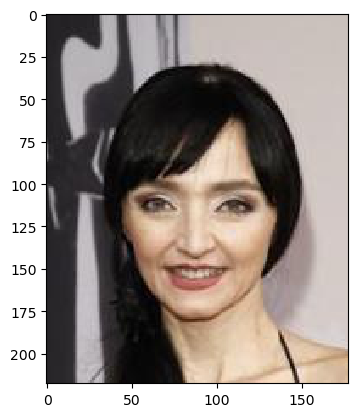

In [18]:
# check data contains images
print(celeba_dataset[0].shape)

celeba_dataset.plot_image(45)

In [19]:
## Dataloader
dataloader_train = DataLoader(celeba_dataset, batch_size=16)

In [8]:
for batch in dataloader_train:
    inputs = batch
    print(batch.shape)
    break

torch.Size([16, 218, 178, 3])


# Helper Functions

In [20]:
# functions to generate random data

def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [21]:
# modified from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

## Discriminator Network

In [22]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View(218*178*3),
            
            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),
            
            nn.LayerNorm(100),
            
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(torch.tensor(inputs, dtype=torch.float32, device=device))
    
    
    def train(self, data_loader, targets):
        # calculate the output of the network
        for inputs in data_loader:
            outputs = self.forward(inputs)
            
            # calculate loss
            loss = self.loss_function(outputs, targets)
    
            # increase counter and accumulate error every 10
            self.counter += 1;
            if (self.counter % 10 == 0):
                self.progress.append(loss.item())
                pass
            if (self.counter % 1000 == 0):
                print("counter = ", self.counter)
                pass
            
            loss.backward()

        # zero gradients, perform a backward pass, update weights
        self.optimiser.step()
        self.optimiser.zero_grad()
        #loss.backward()
        #self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

## Test Discriminator

In [17]:
%%time
# test discriminator can separate real data from random noise

D = Discriminator().to(device)
# move model to cuda device
#D.to(device)


#for image_data_tensor in celeba_dataset:
for image_data_tensor in dataloader_train:
    # real data
    D.train(image_data_tensor, torch.tensor([1.0], dtype=torch.float32, device=device))
    # fake data
    D.train(generate_random_image((16,218,178,3)), torch.tensor([0.0], dtype=torch.float32, device=device))
    pass

/var/folders/s7/fxyhphlx22x1_wch4sxjtr1w0000gn/T/ipykernel_48753/1947141493.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.model(torch.tensor(inputs, dtype=torch.float32, device=device))


counter =  1000


KeyboardInterrupt: 

## Durch Verwendung der GPU "mps" konnte die Zeit von 69min auf 17min reduziert werden

### Weiterer Test indem der ganze Tensor davor schon erstellt wird und nicht erst beim Funktionsaufruf

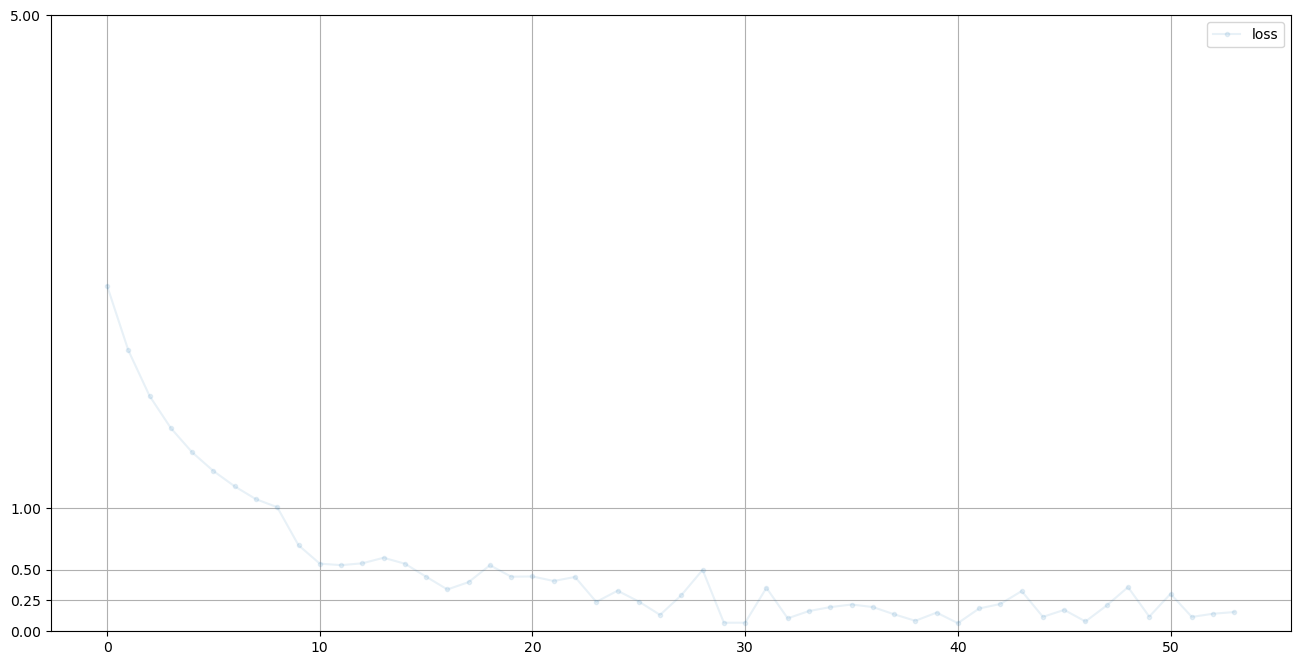

In [11]:
# plot discriminator loss

D.plot_progress()

In [12]:
# manually run discriminator to check it can tell real data from fake

for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image((218,178,3))).item() )
  pass

0.9155330061912537
0.9133011698722839
0.9574787020683289
0.947830080986023
0.12573431432247162
0.12739408016204834
0.12572629749774933
0.12673403322696686


/var/folders/s7/fxyhphlx22x1_wch4sxjtr1w0000gn/T/ipykernel_18323/507561648.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.model(torch.tensor(inputs, dtype=torch.float32, device=device))


## Generator Network

In [23]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),
            
            nn.LayerNorm(3*10*10),
            
            nn.Linear(3*10*10, 3*218*178),
            
            nn.Sigmoid(),
            View((218,178,3))
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        # simply run model
        return self.model(torch.tensor(inputs, dtype=torch.float32, device=device))
    
    
    def train(self, D, data_loader, targets):
        # calculate the output of the network
        for inputs in data_loader:
            g_output = self.forward(inputs)
            
            # pass onto Discriminator
            d_output = D.forward(g_output)
            
            # calculate error
            loss = D.loss_function(d_output, targets)
    
            # increase counter and accumulate error every 10
            self.counter += 1;
            if (self.counter % 10 == 0):
                self.progress.append(loss.item())
                pass
            loss.backward()
        # zero gradients, perform a backward pass, update weights
        self.optimiser.step()
        self.optimiser.zero_grad()
        #loss.backward()
        #self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

## Test Generator Output

/var/folders/s7/fxyhphlx22x1_wch4sxjtr1w0000gn/T/ipykernel_37133/2545958464.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.model(torch.tensor(inputs, dtype=torch.float32, device=device))


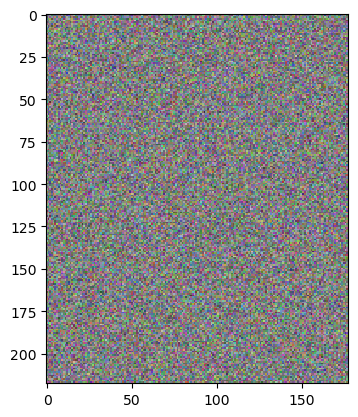

In [24]:
# check the generator output is of the right type and shape

G = Generator()
# move model to cuda device
G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

## Train GAN

In [26]:
%%time 

# create Discriminator and Generator

D = Discriminator().to(device)
G = Generator().to(device)


epochs = 1

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # train Discriminator and Generator

  #for image_data_tensor in celeba_dataset:
  for image_data_tensor in dataloader_train:
    # train discriminator on true
    
    D.train(image_data_tensor, torch.tensor([1.0], dtype=torch.float32, device=device))
    
    # train discriminator on false
    # use detach() so gradients in G are not calculated
    tensor_list = []
    for i in range(16):
        new_tensor = G.forward(generate_random_seed(100)).detach()
        tensor_list.append(new_tensor)
    stacked_tensor = torch.stack(tensor_list, dim=0)
        
    D.train(stacked_tensor, torch.tensor([0.0], dtype=torch.float32, device=device))

    # train generator
    G.train(D, generate_random_seed((16,100)), torch.tensor([1.0], dtype=torch.float32, device=device))

    pass
    
  pass

epoch =  1
shape of one batchtorch.Size([16, 218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
inp

/var/folders/s7/fxyhphlx22x1_wch4sxjtr1w0000gn/T/ipykernel_37133/4270656541.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.model(torch.tensor(inputs, dtype=torch.float32, device=device))
/var/folders/s7/fxyhphlx22x1_wch4sxjtr1w0000gn/T/ipykernel_37133/2545958464.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.model(torch.tensor(inputs, dtype=torch.float32, device=device))


input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178, 3])
input shape of one batch from dataloader:torch.Size([218, 178,

KeyboardInterrupt: 

## with GPU on Apple M1 22:45min

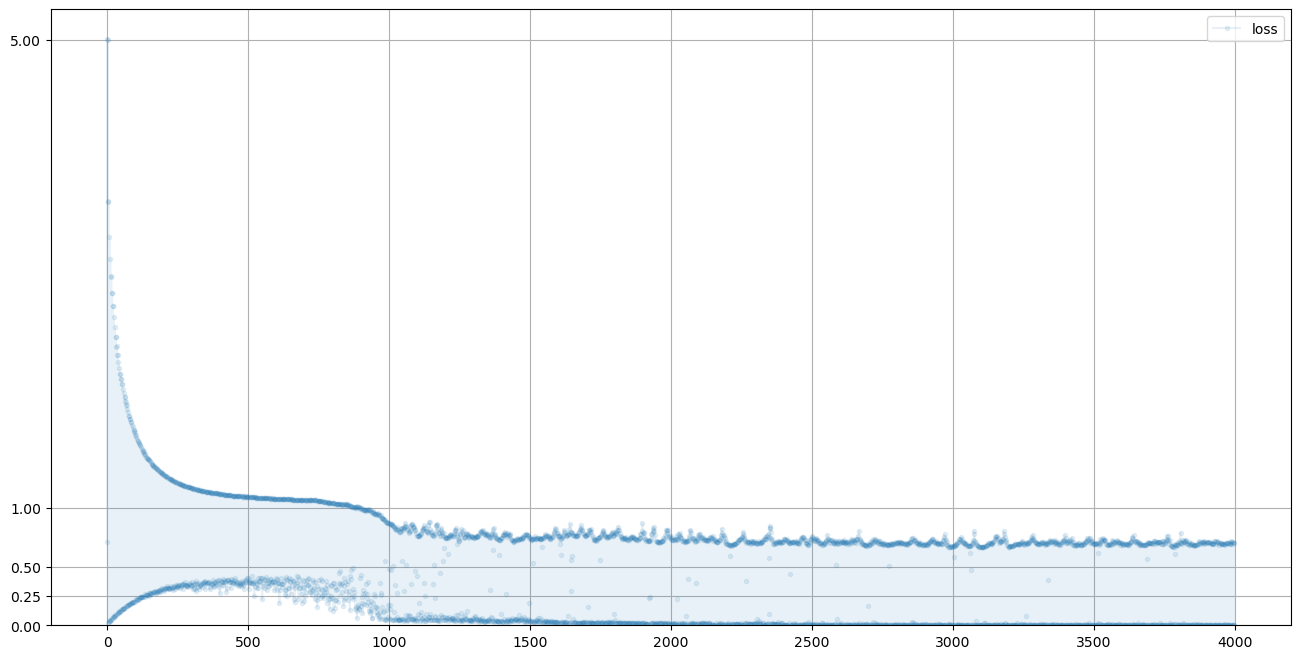

In [12]:
# plot discriminator error

D.plot_progress()

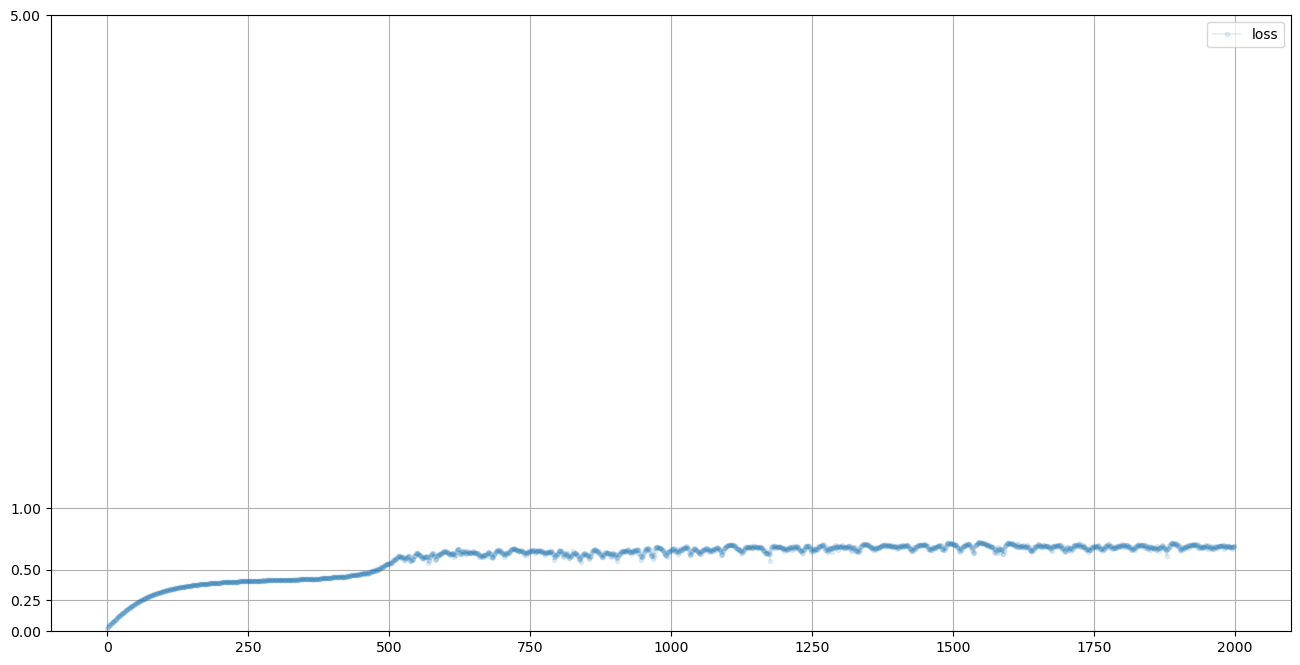

In [13]:
# plot generator error

G.plot_progress()

## Save Models

In [14]:
torch.save(D.state_dict(), 'CPUDiscriminator_batch.pth')
torch.save(G.state_dict(), 'CPUGenerator_batch.pth')



## Run Generator

/var/folders/s7/fxyhphlx22x1_wch4sxjtr1w0000gn/T/ipykernel_55526/2545958464.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.model(torch.tensor(inputs, dtype=torch.float32, device=device))


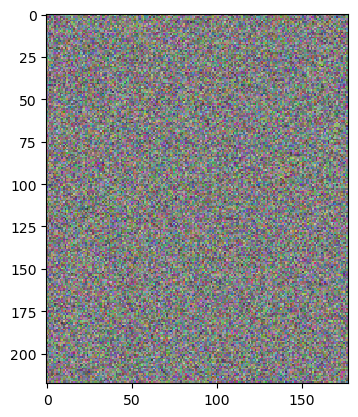

In [15]:
# plot several outputs from the trained generator
import torch
# saved_model = torch.load('GPUDiscriminator_works.pth')
# generator_model = torch.load('GPUGenerator_works.pth')
# 
# # Load the state dictionary onto your model
# D = Discriminator().to(device)
# D.load_state_dict(saved_model)
# G = Generator().to(device)
# G.load_state_dict(generator_model)
# 
# print(D.state_dict())

# plot a 3 column, 2 row array of generated images
#f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass
    pass

# Memory Consumption

In [ ]:
# current memory allocated to tensors (in Gb)

#torch.cuda.memory_allocated(device) / (1024*1024*1024)

In [ ]:
# total memory allocated to tensors during program (in Gb)

#torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

In [ ]:
# summary of memory consumption

#print(torch.cuda.memory_summary(device, abbreviated=True))